Questions posées :
- Mesurer l'impact du COVID sur le trafic de manière globale et locale.
- Y-a-t-il des facteurs démographiques qui sont correlable avec le trafic ?
- Peut-on créer un modèle viable d'estimation du trafic à partir de quelques facteurs démographiques ?

# Première exploration et nettoyage de la donnée ouverte de la RATP

>Tout d'abord, j'importe les librairies utiles au projet :

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

> J'importe le dataset par année:



In [ ]:
data_set_par_annee={"2013":"","2014":"","2015":"","2016":"","2017":"","2018":"","2019":"","2020":"","2021":""}

for annee in range(2013,2022) :
  data_set_par_annee[annee]=pd.read_csv("trafic-annuel-entrant-par-station-du-reseau-ferre-"+str(annee)+".csv", sep = ";")

#Le dataset de 2016 possède des colonnes en trop
data_set_par_annee[2016] = data_set_par_annee[2016].drop(columns=["Column 12","Column 13","Column 14","Column 15"], axis=1)

for annee in range(2013,2022) :
  data_set_par_annee[annee].loc[data_set_par_annee[annee]['Station'] == 'SAINT-MICHEL-NOTRE-DAME', 'Arrondissement pour Paris'] = 5
  data_set_par_annee[annee].loc[data_set_par_annee[annee]['Ville'] == 'Asnières', 'Ville'] = "Asnières sur Seine"
  data_set_par_annee[annee].loc[data_set_par_annee[annee]['Ville'] == 'Neuilly Sur Seine', 'Ville'] = "Neuilly-sur-Seine"
  data_set_par_annee[annee].loc[data_set_par_annee[annee]['Ville'] == 'Saint Ouen', 'Ville'] = "Saint-ouen"
  data_set_par_annee[annee].loc[data_set_par_annee[annee]['Ville'] == 'Maisons -Alfort', 'Ville'] = "Maisons-Alfort"
  data_set_par_annee[annee].loc[data_set_par_annee[annee]['Ville'] == 'Saint Denis / Aubervilliers', 'Ville'] = "Saint Denis"


ATTENTION : après vérification, il y a plusieurs problèmes sur ces datasets : 
- Le dataset de 2016 possède 4 colonnes en trop avec aucune donnée
- Le dataset de 2014 ne possède pas d'arrondisement pour une dizaine de stations parisiennes (j'ai modifié dirrectement le document en question)
- Tous les datasets n'ont pas d'arrondisement indiqué pour la station de Saint-Michel-Notre-Dame
- Certaines villes ne sont pas écrites de manière identique (par exemple Asnières/Asnières sur Seine, Neuilly-sur-Seine/Neuilly Sur Seine, Saint Ouen/Saint-ouen)

Je vais oppérer une dernière modification (mais qui n'est pas une erreurs dans le dataset), je place la station FRONT POPULAIRE qui est à Saint Denis / Aubervilliers seulement à Saint Denis (cela me permet d'avoir une unicité sur le champs ville)





> Vérification des modifications (je montre ici seulement pour 2014 pour alléger) :



In [ ]:
print(data_set_par_annee[2014][data_set_par_annee[2014]['Station'] == 'SAINT-MICHEL-NOTRE-DAME']['Arrondissement pour Paris'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Asnières']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Asnières sur Seine']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Neuilly Sur Seine']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Neuilly-sur-Seine']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Saint Ouen']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Saint-ouen']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Maisons -Alfort']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Maisons-Alfort']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Saint Denis / Aubervilliers']['Ville'])
print(data_set_par_annee[2014][data_set_par_annee[2014]['Ville'] == 'Saint Denis']['Ville'])

print(data_set_par_annee[2016].columns)

239    5.0
Name: Arrondissement pour Paris, dtype: float64
Series([], Name: Ville, dtype: object)
53     Asnières sur Seine
90     Asnières sur Seine
221    Asnières sur Seine
Name: Ville, dtype: object
Series([], Name: Ville, dtype: object)
4      Neuilly-sur-Seine
5      Neuilly-sur-Seine
250    Neuilly-sur-Seine
Name: Ville, dtype: object
Series([], Name: Ville, dtype: object)
16    Saint-ouen
83    Saint-ouen
Name: Ville, dtype: object
Series([], Name: Ville, dtype: object)
328    Maisons-Alfort
346    Maisons-Alfort
349    Maisons-Alfort
Name: Ville, dtype: object
Series([], Name: Ville, dtype: object)
36     Saint Denis
68     Saint Denis
75     Saint Denis
134    Saint Denis
355    Saint Denis
Name: Ville, dtype: object
Index(['Rang', 'Réseau', 'Station', 'Trafic', 'Correspondance_1',
       'Correspondance_2', 'Correspondance_3', 'Correspondance_4',
       'Correspondance_5', 'Ville', 'Arrondissement pour Paris'],
      dtype='object')


Voici nos données corrigées :

In [ ]:
print(data_set_par_annee[2021].head())
print(data_set_par_annee[2021].dtypes)

   Rang Réseau               Station    Trafic Correspondance_1  \
0     3  Métro          GARE DE LYON  28640475                1   
1    12  Métro            BELLEVILLE   7314438                2   
2    32  Métro                 OPERA   5193831                3   
3    58  Métro  SAINT-MANDE-TOURELLE   3944640                1   
4    59  Métro                 HOCHE   3928404                5   

  Correspondance_2 Correspondance_3  Correspondance_4  Correspondance_5  \
0               14                A               NaN               NaN   
1               11              NaN               NaN               NaN   
2                7                8               NaN               NaN   
3              NaN              NaN               NaN               NaN   
4              NaN              NaN               NaN               NaN   

         Ville  Arrondissement pour Paris  
0        Paris                       12.0  
1        Paris                       10.0  
2        Paris

Maintenant pour éviter les valeurs nul dans mon dataset je vais basculer les informations de correspondances par des booléens avec une colonne pour chaque ligne.

Je souhaite aussi compter le nombre de correspondances par station.

Je pourrais ensuite supprimer du tableau mes colonnes correspondances.

In [ ]:
liste_ligne= ["A","B","1","2","3","3bis","4","5","6","7","7bis","8","9","10","11","12","13","14"]
for annee in range(2013,2022) :
  for ligne in liste_ligne:
    data_set_par_annee[annee][ligne] = False
    for station_id in range(len(data_set_par_annee[annee])):
      if data_set_par_annee[annee]['Correspondance_1'][station_id]==ligne or data_set_par_annee[annee]['Correspondance_2'][station_id]==ligne or data_set_par_annee[annee]['Correspondance_3'][station_id]==ligne or data_set_par_annee[annee]['Correspondance_4'][station_id]==ligne or data_set_par_annee[annee]['Correspondance_5'][station_id]==ligne :
        data_set_par_annee[annee].loc[station_id,ligne]=True

In [ ]:
for annee in range(2013,2022) :
  data_set_par_annee[annee]["nb_correspondances"]=0
  for station_id in range(len(data_set_par_annee[annee])):
    for i in range(1,6) :
      if data_set_par_annee[annee]['Correspondance_'+str(i)][station_id] in liste_ligne :
        data_set_par_annee[annee].loc[station_id, "nb_correspondances"] += 1

In [ ]:
for annee in range(2013,2022) :
  for i in range(1,6):
    del data_set_par_annee[annee]['Correspondance_'+str(i)]

Je rajoute pour chaque dataset une colonne année me permettant de les fusionner dans le futur sans perdre cette information

In [ ]:
for annee in range(2013,2022) :
  data_set_par_annee[annee]["Année"]=annee

Je peux maintenant vérifier les nouvelles données ainsi créées :

In [ ]:
print(data_set_par_annee[2021].head())
print(data_set_par_annee[2021].dtypes)

   Rang Réseau               Station    Trafic        Ville  \
0     3  Métro          GARE DE LYON  28640475        Paris   
1    12  Métro            BELLEVILLE   7314438        Paris   
2    32  Métro                 OPERA   5193831        Paris   
3    58  Métro  SAINT-MANDE-TOURELLE   3944640  Saint Mandé   
4    59  Métro                 HOCHE   3928404       Pantin   

   Arrondissement pour Paris      A      B      1      2  ...   7bis      8  \
0                       12.0   True  False   True  False  ...  False  False   
1                       10.0  False  False  False   True  ...  False  False   
2                        9.0  False  False  False  False  ...  False   True   
3                        NaN  False  False   True  False  ...  False  False   
4                        NaN  False  False  False  False  ...  False  False   

       9     10     11     12     13     14  nb_correspondances  Année  
0  False  False  False  False  False   True                   3   2021  


Remarque : Le type float pour les arrondissements est lié au "NaN" utilisé pour les stations n'étant pas dans Paris

# Premières analyses et observations

Essayons d'explorer un peu ces premières données :

In [ ]:
# Initialisation de la liste des dataframes à concaténer
df_list = []

# Ajout de chaque dataframe à la liste
for annee in range(2013, 2022):
    df_list.append(data_set_par_annee[annee])

# Concaténation des dataframes
dataset_complet = pd.concat(df_list, axis=0)

In [ ]:
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

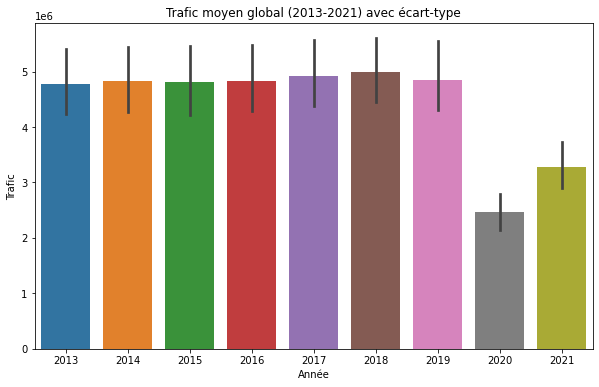

In [ ]:
plt.figure(figsize=(10,6))
df_plot = dataset_complet[['Année', 'Trafic']]
sns.barplot(x='Année', y='Trafic', data=df_plot)
plt.title("Trafic moyen global (2013-2021) avec écart-type")
plt.show()

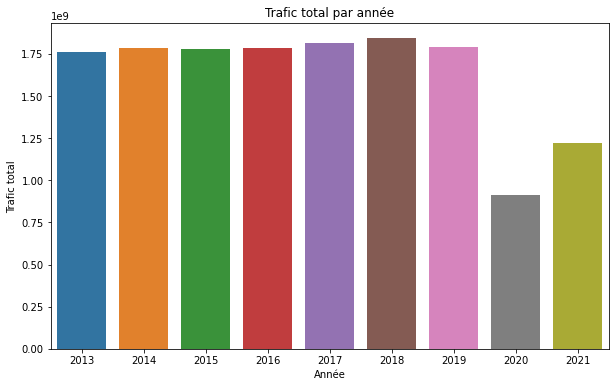

In [ ]:
# Création du dataframe à partir des données totales par année
df_trafic_total = pd.DataFrame({'Année': list(range(2013,2022)), 'Trafic total': [data_set_par_annee[annee]['Trafic'].sum() for annee in range(2013,2022)]})

# Affichage du graphique à barres
plt.figure(figsize=(10,6))
sns.barplot(x='Année', y='Trafic total', data=df_trafic_total)
plt.title("Trafic total par année")
plt.show()

On remarque déjà l'effet fort du Covid sur les années 2020 et 2021. Je décide donc de les retirer de mes futurs graphiques globaux pour moins fausser la moyenne et l'écart type (me permettant de comparer ces tendances globales aux annéees 2020-2021)

In [ ]:
# Initialisation de la liste des dataframes à concaténer
df_list = []

# Ajout de chaque dataframe à la liste
for annee in range(2013, 2020):
    df_list.append(data_set_par_annee[annee])

# Concaténation des dataframes
dataset_hors_covid = pd.concat(df_list, axis=0)

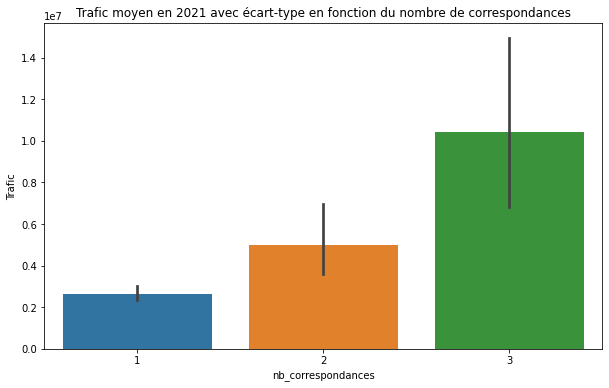

In [ ]:
plt.figure(figsize=(10,6))
df_plot = data_set_par_annee[2021][['nb_correspondances', 'Trafic']]
sns.barplot(x='nb_correspondances', y='Trafic', data=df_plot)
plt.title("Trafic moyen en 2021 avec écart-type en fonction du nombre de correspondances")
plt.show()

On remarque, de manière logique, que le nombre de correspondance influe fortement sur le trafic moyen d'une station.

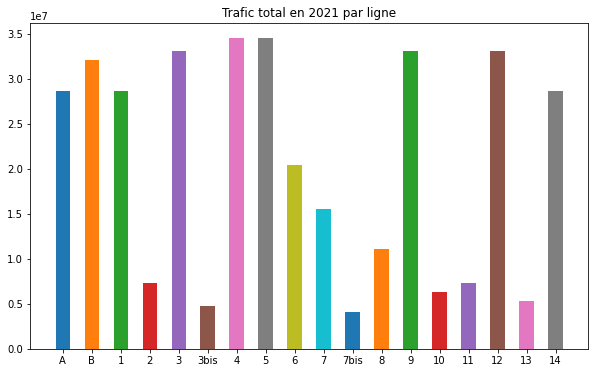

In [ ]:
df_plot = data_set_par_annee[2021][liste_ligne + ['Trafic']]

plt.figure(figsize=(10,6))
x_values = list(range(len(liste_ligne)))

for i, x in enumerate(x_values):
    plt.bar(x, df_plot[df_plot[liste_ligne[i]] != False]['Trafic'], width=0.5)
plt.xticks(x_values, liste_ligne)
plt.title("Trafic total en 2021 par ligne")
plt.show()

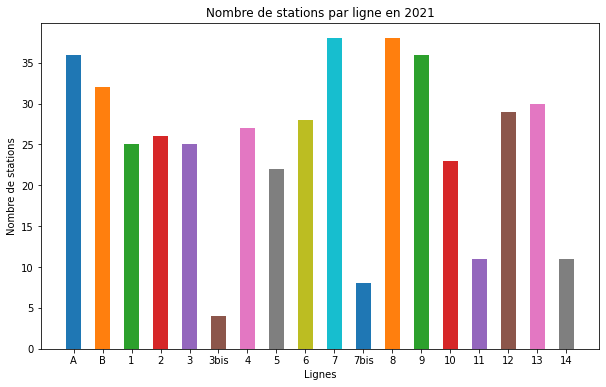

In [ ]:
df_plot = data_set_par_annee[2021][liste_ligne]

plt.figure(figsize=(10,6))
x_values = list(range(len(liste_ligne)))

for i, x in enumerate(x_values):
    y = df_plot[df_plot[liste_ligne[i]] != False].shape[0]
    plt.bar(x, y, width=0.5)
plt.xticks(x_values, liste_ligne)
plt.xlabel("Lignes")
plt.ylabel("Nombre de stations")
plt.title("Nombre de stations par ligne en 2021")
plt.show()

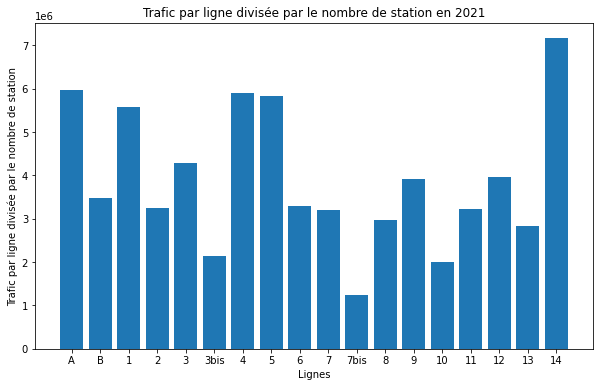

In [ ]:
df_plot = data_set_par_annee[2021][liste_ligne + ['Trafic']]

trafic_par_station = {}

for ligne in liste_ligne:
    nb_stations = len(df_plot[df_plot[ligne] != False])
    trafic_total = df_plot[df_plot[ligne] != False]['Trafic'].sum()
    trafic_par_station[ligne] = trafic_total / nb_stations

plt.figure(figsize=(10,6))
plt.bar(trafic_par_station.keys(), trafic_par_station.values())
plt.xlabel("Lignes")
plt.ylabel("Trafic par ligne divisée par le nombre de station")
plt.title("Trafic par ligne divisée par le nombre de station en 2021")
plt.show()

On peut remarquer que les métros 3bis, 7bis et 10 sont moins générateur de trafic (et surement moins rentable)

En vue comparée, le trafic moyen entre le trafic moyen global, celui des stations à multiples correspondances et celui des stations isolées :

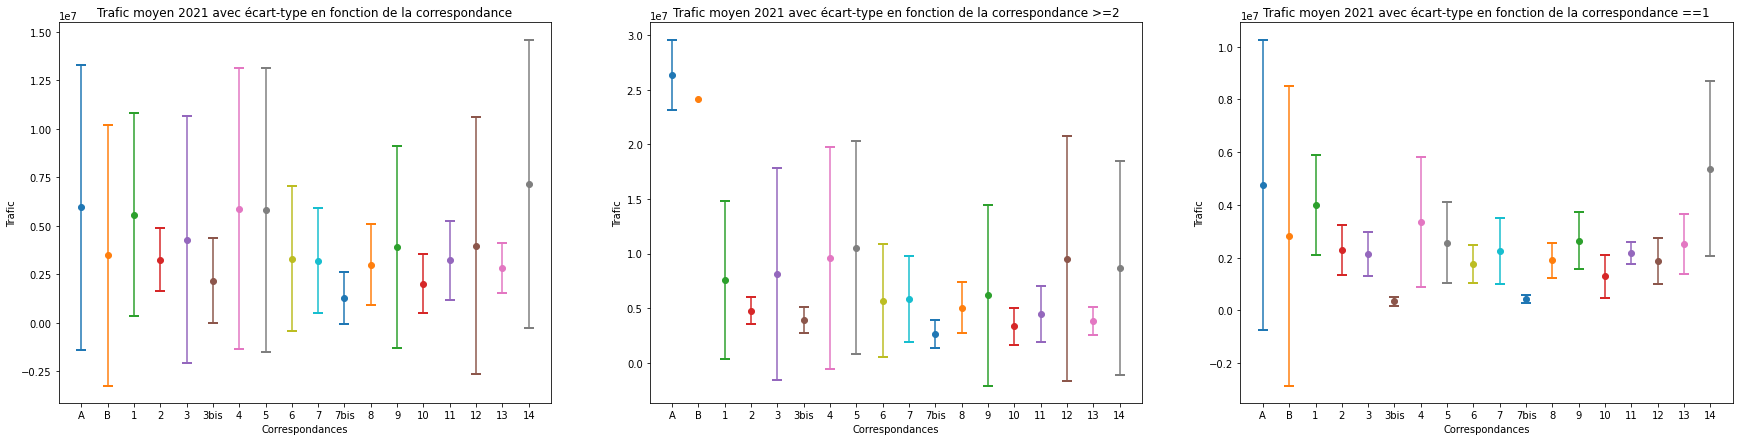

In [ ]:
df_plot = data_set_par_annee[2021][liste_ligne +['Trafic','nb_correspondances']]

# Création de la figure avec 3 sous-graphiques disposés sur une ligne
fig, axs = plt.subplots(1, 3, figsize=(30, 7))

# Premier graphique
for i, x in enumerate(x_values):
    y = df_plot[df_plot[liste_ligne[i]] != False]['Trafic']
    y_mean = statistics.mean(y)
    y_stdev = statistics.stdev(y)
    axs[0].errorbar(x, y_mean, yerr=y_stdev, fmt='o', capsize=5, capthick=2)
axs[0].set_xticks(x_values)
axs[0].set_xticklabels(liste_ligne)
axs[0].set_xlabel("Correspondances")
axs[0].set_ylabel("Trafic")
axs[0].set_title("Trafic moyen 2021 avec écart-type en fonction de la correspondance")

# Deuxième graphique
for i, x in enumerate(x_values):
    y = df_plot[(df_plot[liste_ligne[i]] != False) & (df_plot['nb_correspondances'] >=2)]['Trafic']
    y_mean = statistics.mean(y)
    if len(y) >= 2:
        y_stdev = statistics.stdev(y)
    else:
        y_stdev = None
    axs[1].errorbar(x, y_mean, yerr=y_stdev, fmt='o', capsize=5, capthick=2)
axs[1].set_xticks(x_values)
axs[1].set_xticklabels(liste_ligne)
axs[1].set_xlabel("Correspondances")
axs[1].set_ylabel("Trafic")
axs[1].set_title("Trafic moyen 2021 avec écart-type en fonction de la correspondance >=2")

# Troisième graphique
for i, x in enumerate(x_values):
    y = df_plot[(df_plot[liste_ligne[i]] != False) & (df_plot['nb_correspondances'] ==1)]['Trafic']
    y_mean = statistics.mean(y)
    if len(y) >= 2:
        y_stdev = statistics.stdev(y)
    else:
        y_stdev = None
    axs[2].errorbar(x, y_mean, yerr=y_stdev, fmt='o', capsize=5, capthick=2)
axs[2].set_xticks(x_values)
axs[2].set_xticklabels(liste_ligne)
axs[2].set_xlabel("Correspondances")
axs[2].set_ylabel("Trafic")
axs[2].set_title("Trafic moyen 2021 avec écart-type en fonction de la correspondance ==1")
plt.show()

On peut observer plusieurs choses :
- Les stations à correspondances multiples sont plus utilisées que les isolées
- Les correspondances multiples avec les rer A et B ont un trafic signicativement supérieur aux autres correspondances multiples
- Certaines stations de RER A et B isolées sont moins utilisées que les stations de métros isolées
- Le métro 14 semble largement plus utilisé sur l'intégralité de sa ligne (en comparaison des autres lignes), il ne possède pas de station avec un trafic faible. (cela peut s'expliquer en partie par son plus faible nombre de station)
- Les lignes 2, 3bis, 7bis, 10, 11 et 13 sont largement moins utilisées que les autres lignes.
- Les plus gros écart de trafic observable sur une même ligne sont les rer A et B et les métros 4, 5, 12 et 14. De plus ce sont ces mêmes lignes qui génère le plus de trafic au total (en comparrant avec les graphiques précédants)

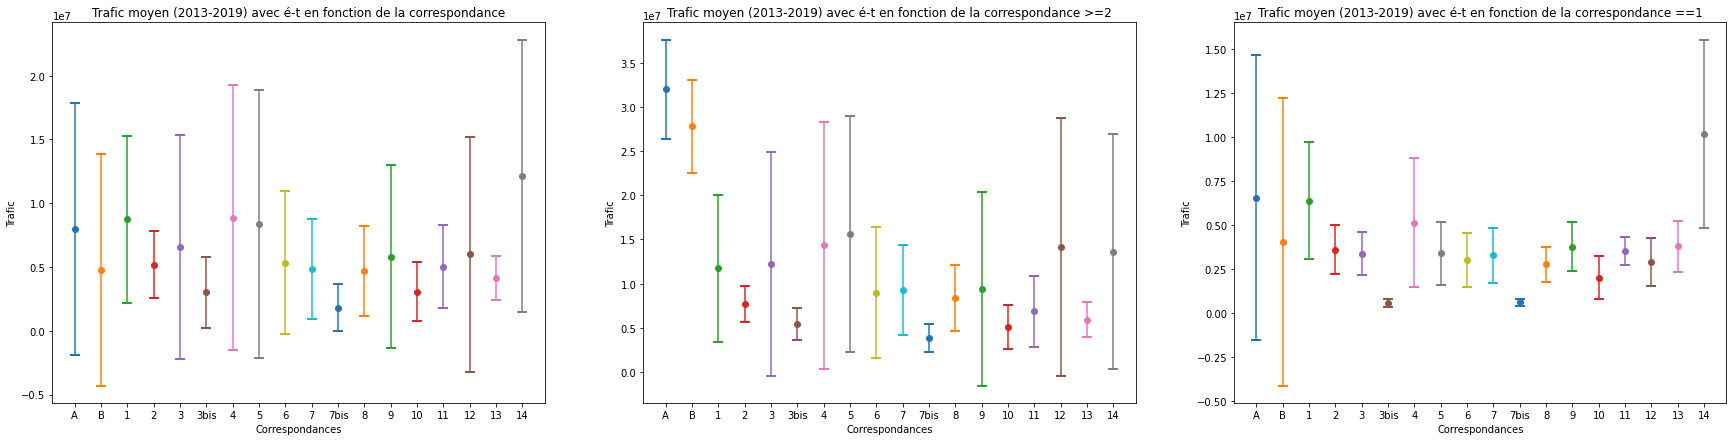

In [ ]:
df_plot = dataset_hors_covid[liste_ligne + ['Trafic','nb_correspondances']]

# Création de la figure avec 3 sous-graphiques disposés sur une ligne
fig, axs = plt.subplots(1, 3, figsize=(30, 7))

# Premier graphique
for i, x in enumerate(x_values):
    y = df_plot[df_plot[liste_ligne[i]] != False]['Trafic']
    y_mean = statistics.mean(y)
    y_stdev = statistics.stdev(y)
    axs[0].errorbar(x, y_mean, yerr=y_stdev, fmt='o', capsize=5, capthick=2)
axs[0].set_xticks(x_values)
axs[0].set_xticklabels(liste_ligne)
axs[0].set_xlabel("Correspondances")
axs[0].set_ylabel("Trafic")
axs[0].set_title("Trafic moyen (2013-2019) avec é-t en fonction de la correspondance")

# Deuxième graphique
for i, x in enumerate(x_values):
    y = df_plot[(df_plot[liste_ligne[i]] != False) & (df_plot['nb_correspondances'] >=2)]['Trafic']
    y_mean = statistics.mean(y)
    if len(y) >= 2:
        y_stdev = statistics.stdev(y)
    else:
        y_stdev = None
    axs[1].errorbar(x, y_mean, yerr=y_stdev, fmt='o', capsize=5, capthick=2)
axs[1].set_xticks(x_values)
axs[1].set_xticklabels(liste_ligne)
axs[1].set_xlabel("Correspondances")
axs[1].set_ylabel("Trafic")
axs[1].set_title("Trafic moyen (2013-2019) avec é-t en fonction de la correspondance >=2")

# Troisième graphique
for i, x in enumerate(x_values):
    y = df_plot[(df_plot[liste_ligne[i]] != False) & (df_plot['nb_correspondances'] ==1)]['Trafic']
    y_mean = statistics.mean(y)
    if len(y) >= 2:
        y_stdev = statistics.stdev(y)
    else:
        y_stdev = None
    axs[2].errorbar(x, y_mean, yerr=y_stdev, fmt='o', capsize=5, capthick=2)
axs[2].set_xticks(x_values)
axs[2].set_xticklabels(liste_ligne)
axs[2].set_xlabel("Correspondances")
axs[2].set_ylabel("Trafic")
axs[2].set_title("Trafic moyen (2013-2019) avec é-t en fonction de la correspondance ==1")
plt.show()

A part une baisse du trafic global, le covid ne semble pas avoir affecté les dynamyques sur les différentes lignes. Les observations faites sur 2021 sont aussi valable au global.

**Conclusion :**
- Le covid a affecté le trafic au global (à savoir le trafic total et individuel par station) mais pas les dynamiques (les parts du traffic par stations sont resté sensiblement les même)
- Les lignes générant le plus de traffic sont celles qui ont aussi le plus de disparité de trafic par station
- 2, 3bis, 7bis, 10, 11 et 13 sont largement moins utilisées que les autres lignes.

# Rajout de données démographique

Maintenant qu'on a exploré les données de la RATP de manière brut, j'aimerais y ajouter des informations démographiques pour chaque ville.

Je vais rajouter 5 colonnes :
- La population totale de la ville 
- Le salaire net horaire moyen dans la ville
- La distance au centre de Paris
- La superficie de la ville
- Le nombre de station dans la ville

Pour cela j'ai créé deux fichiers .csv regrouppant ces informations depuis les sources suivantes (un pour les villes et un pour les arrondisements) :

- La population totale des villes vient du Recensement de la population de l'INSEE de 2020 (https://www.insee.fr/fr/statistiques/6683035?sommaire=6683037).
- Le salaire net moyen horaire par ville de l'étude de l'INSEE de 2020 sur les salaires net horaire moyen (https://www.insee.fr/fr/statistiques/2021266).
- La distance des villes au centre de Paris a été obtenu grâce à des mesures manuelles sur Google map
- La superficie des villes a été obtenue via la superficie indiquée sur Wikipedia (en km²)
- Le nombre de station dans la ville est calculé à partir des stations dans les données de la RATP (ie. les datasets de ce projet)


Cette étape de création de csv étant réalisé, je vais maintenant rajouter mes données à mes dataframes existant :

In [ ]:
import csv

ville_dict = {}

with open('Donnees_villes.csv') as csv_file:
  reader = csv.reader(csv_file, delimiter=';')
  # Ignore la première ligne (en-têtes de colonnes)
  next(reader)
  for row in reader:
    # Récupérer le nom de la ville et enlever les espaces inutiles
    ville = row[0].strip()
    # Ajouter la ville au dictionnaire avec les autres informations comme valeur
    ville_dict[ville] = {
      'Population': int(row[1]),
      'Salaire net horaire moyen': float(row[2]),
      'Distance de Paris': float(row[3]),
      'Superficie': float(row[4])
    }

print(ville_dict)


arrondissements_dict = {}

with open('Donnees_arrondissements.csv') as csv_file:
  reader = csv.reader(csv_file, delimiter=';')
  # Ignore la première ligne (en-têtes de colonnes)
  next(reader)
  for row in reader:
    # Récupérer le nom de l'arrondissement et enlever les espaces inutiles
    arrondissement = row[0].strip()
    # Ajouter l'arrondissement au dictionnaire avec les autres informations comme valeur
    arrondissements_dict[arrondissement] = {
      'Population': int(row[1]),
      'Salaire net horaire moyen': float(row[2]),
      'Distance de Paris': float(row[3]),
      'Superficie': float(row[4])
    }

print(arrondissements_dict)

{'Antony': {'Population': 63319, 'Salaire net horaire moyen': 24.64, 'Distance de Paris': 12.44, 'Superficie': 9.56}, 'Asnieres sur Seine': {'Population': 68987, 'Salaire net horaire moyen': 23.99, 'Distance de Paris': 7.32, 'Superficie': 4.82}, 'Aubervilliers': {'Population': 86597, 'Salaire net horaire moyen': 12.38, 'Distance de Paris': 6.57, 'Superficie': 5.76}, 'Bagnolet': {'Population': 35797, 'Salaire net horaire moyen': 15.55, 'Distance de Paris': 5.86, 'Superficie': 2.57}, 'Bobigny': {'Population': 53814, 'Salaire net horaire moyen': 12.17, 'Distance de Paris': 8.85, 'Superficie': 6.77}, 'Boissy-Saint-Léger': {'Population': 16426, 'Salaire net horaire moyen': 15.19, 'Distance de Paris': 16.96, 'Superficie': 8.94}, 'Boulogne Billancourt': {'Population': 145159, 'Salaire net horaire moyen': 30.48, 'Distance de Paris': 7.93, 'Superficie': 6.17}, 'Bourg la Reine': {'Population': 21009, 'Salaire net horaire moyen': 26.15, 'Distance de Paris': 8.88, 'Superficie': 1.87}, 'Bry-sur-Mar

In [ ]:
pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import unidecode

#Fonction qui permet de comparer 2 string sans prendre en compte les accents et les tirets/espaces
def compare_strings(s1: str, s2: str) -> bool:
    # Suppression des accents et transformation en minuscule
    s1 = unidecode.unidecode(s1).lower()
    s2 = unidecode.unidecode(s2).lower()
    # Suppression des espaces et tirets
    s1 = s1.replace(" ", "").replace("-", "")
    s2 = s2.replace(" ", "").replace("-", "")
    # Comparaison des chaînes
    return s1 == s2

for annee in range(2013,2022) :
  nb_stations_par_ville = {}
  nb_stations_par_arrondisement = {}
  #Permet de compter le nombre de station par ville
  for ville in data_set_par_annee[annee]['Ville']:
    if ville not in nb_stations_par_ville:
        nb_stations_par_ville[ville] = 1
    else:
        nb_stations_par_ville[ville] += 1
  #Permet de compter le nombre de station par arrondissement
  for arrondissement in data_set_par_annee[annee]['Arrondissement pour Paris']:
    if arrondissement > 0 :
      if arrondissement not in nb_stations_par_arrondisement:
        nb_stations_par_arrondisement[arrondissement] = 1
      else:
        nb_stations_par_arrondisement[arrondissement] += 1
  #Initialise chaque nouvelle colonne
  data_set_par_annee[annee]['Superficie']=0.0
  data_set_par_annee[annee]['Salaire_moyen']=0.0
  data_set_par_annee[annee]['Distance_paris']=0.0
  data_set_par_annee[annee]['Population']=0
  data_set_par_annee[annee]['Nb_station_ville_ou_arrondissement']=0
  #On va naviguer sur chacune des ligne du dataframe pour y ajouter les élémments correspondants
  for station_id in range(len(data_set_par_annee[annee])):
    if (compare_strings(data_set_par_annee[annee]['Ville'][station_id],"Paris")) :
      for arrondissement, data in arrondissements_dict.items() :
        if (float(arrondissement)==float(data_set_par_annee[annee]['Arrondissement pour Paris'][station_id])) :
          data_set_par_annee[annee].loc[station_id, 'Superficie'] = data["Superficie"]
          data_set_par_annee[annee].loc[station_id, 'Salaire_moyen'] = data["Salaire net horaire moyen"]
          data_set_par_annee[annee].loc[station_id, 'Distance_paris'] = data["Distance de Paris"]
          data_set_par_annee[annee].loc[station_id, 'Population'] = data["Population"]
          data_set_par_annee[annee].loc[station_id, 'Nb_station_ville_ou_arrondissement'] = nb_stations_par_arrondisement[data_set_par_annee[annee]['Arrondissement pour Paris'][station_id]]
    else :
      for ville, data in ville_dict.items() :
        if (compare_strings(data_set_par_annee[annee]['Ville'][station_id],ville)):
          data_set_par_annee[annee].loc[station_id, 'Superficie'] = data["Superficie"]
          data_set_par_annee[annee].loc[station_id, 'Salaire_moyen'] = data["Salaire net horaire moyen"]
          data_set_par_annee[annee].loc[station_id, 'Distance_paris'] = data["Distance de Paris"]
          data_set_par_annee[annee].loc[station_id, 'Population'] = data["Population"]
          data_set_par_annee[annee].loc[station_id, 'Nb_station_ville_ou_arrondissement'] = nb_stations_par_ville[data_set_par_annee[annee]['Ville'][station_id]]

In [ ]:
print(data_set_par_annee[2014][(data_set_par_annee[2014]["Superficie"]==0)]["Station"])

Series([], Name: Station, dtype: object)


Remarque : c'est ici que je me suis aperçu qu'il manquait des arrondissement dans le fichier csv de 2014

Je vérifie que tout est bien passé (i.e. valeur à 0 ou incohérente)

In [ ]:
pd.options.display.max_rows = len(data_set_par_annee[2020])
for annee in range(2013,2022) :
  print(data_set_par_annee[annee][(data_set_par_annee[annee]["Distance_paris"]==0.0)])

Empty DataFrame
Columns: [Rang, Réseau, Station, Trafic, Ville, Arrondissement pour Paris, A, B, 1, 2, 3, 3bis, 4, 5, 6, 7, 7bis, 8, 9, 10, 11, 12, 13, 14, nb_correspondances, Année, Superficie, Salaire_moyen, Distance_paris, Population, Nb_station_ville_ou_arrondissement]
Index: []

[0 rows x 31 columns]
Empty DataFrame
Columns: [Rang, Réseau, Station, Trafic, Ville, Arrondissement pour Paris, A, B, 1, 2, 3, 3bis, 4, 5, 6, 7, 7bis, 8, 9, 10, 11, 12, 13, 14, nb_correspondances, Année, Superficie, Salaire_moyen, Distance_paris, Population, Nb_station_ville_ou_arrondissement]
Index: []

[0 rows x 31 columns]
Empty DataFrame
Columns: [Rang, Réseau, Station, Trafic, Ville, Arrondissement pour Paris, A, B, 1, 2, 3, 3bis, 4, 5, 6, 7, 7bis, 8, 9, 10, 11, 12, 13, 14, nb_correspondances, Année, Superficie, Salaire_moyen, Distance_paris, Population, Nb_station_ville_ou_arrondissement]
Index: []

[0 rows x 31 columns]
Empty DataFrame
Columns: [Rang, Réseau, Station, Trafic, Ville, Arrondissement 

In [ ]:
# Initialisation de la liste des dataframes à concaténer
df_list = []

# Ajout de chaque dataframe à la liste
for annee in range(2013, 2022):
    df_list.append(data_set_par_annee[annee])

# Concaténation des dataframes
dataset_complet = pd.concat(df_list, axis=0)

In [ ]:
dataset_complet

,Rang,Réseau,Station,Trafic,Ville,Arrondissement pour Paris,A,B,1,2,...,12,13,14,nb_correspondances,Année,Superficie,Salaire_moyen,Distance_paris,Population,Nb_station_ville_ou_arrondissement
0,12,Métro,OPERA,12269711,Paris,9.0,False,False,False,False,...,False,False,False,3,2013,2.18,32.53,2.69,60071,14
1,19,Métro,NATION,9541406,Paris,12.0,False,False,True,True,...,False,False,False,3,2013,16.32,23.19,6.21,141287,21
2,20,Métro,PALAIS-ROYAL,9385220,Paris,1.0,False,False,True,False,...,False,False,False,2,2013,1.83,31.07,1.50,16395,8
3,39,Métro,GRANDS BOULEVARDS,7092775,Paris,9.0,False,False,False,False,...,False,False,False,2,2013,2.18,32.53,2.69,60071,14
4,41,Métro,MAIRIE DE CLICHY,6987958,Clichy,NaN,False,False,False,False,...,False,True,False,1,2013,5.08,20.54,5.62,61070,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,39,RER,FONTENAY-SOUS-BOIS,2121720,Fontenay-sous-Bois,NaN,True,False,False,False,...,False,False,False,1,2021,5.58,21.35,9.66,53418,2
367,40,RER,SUCY-BONNEUIL,1993503,Sucy-en-Brie,NaN,True,False,False,False,...,False,False,False,1,2021,10.43,20.16,16.79,26709,1
368,58,RER,LE GUICHET,530706,Orsay,NaN,False,True,False,False,...,False,False,False,1,2021,7.97,24.59,20.91,16753,2
369,65,RER,PARC DE SCEAUX,383626,Antony,NaN,False,True,False,False,...,False,False,False,1,2021,9.56,24.64,12.44,63319,5


In [ ]:
data_set_par_annee[2021].head()

,Rang,Réseau,Station,Trafic,Ville,Arrondissement pour Paris,A,B,1,2,...,12,13,14,nb_correspondances,Année,Superficie,Salaire_moyen,Distance_paris,Population,Nb_station_ville_ou_arrondissement
0,3,Métro,GARE DE LYON,28640475,Paris,12.0,True,False,True,False,...,False,False,True,3,2021,16.32,23.19,6.21,141287,21
1,12,Métro,BELLEVILLE,7314438,Paris,10.0,False,False,False,True,...,False,False,False,2,2021,2.89,24.66,2.51,90836,11
2,32,Métro,OPERA,5193831,Paris,9.0,False,False,False,False,...,False,False,False,3,2021,2.18,32.53,2.69,60071,14
3,58,Métro,SAINT-MANDE-TOURELLE,3944640,Saint Mandé,NaN,False,False,True,False,...,False,False,False,1,2021,0.92,28.10,5.81,22835,1
4,59,Métro,HOCHE,3928404,Pantin,NaN,False,False,False,False,...,False,False,False,1,2021,5.01,15.94,6.47,57668,3


Les données démographiques ont été ajoutées avec succès. Maintenant place à leur exploration 😎 !

# Exploration de ces nouvelles données

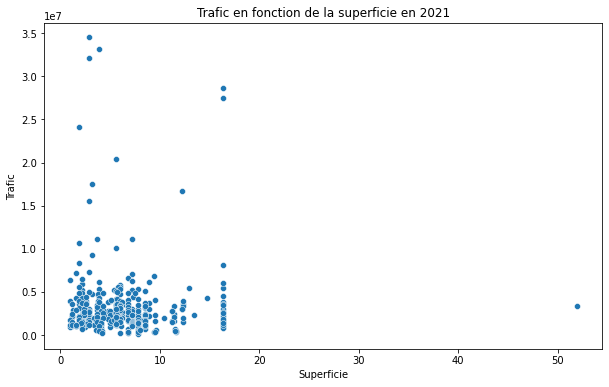

In [ ]:
df_plot = data_set_par_annee[2021][['Superficie', 'Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Superficie', y='Trafic', data=df_plot)
plt.title("Trafic en fonction de la superficie en 2021")
plt.show()

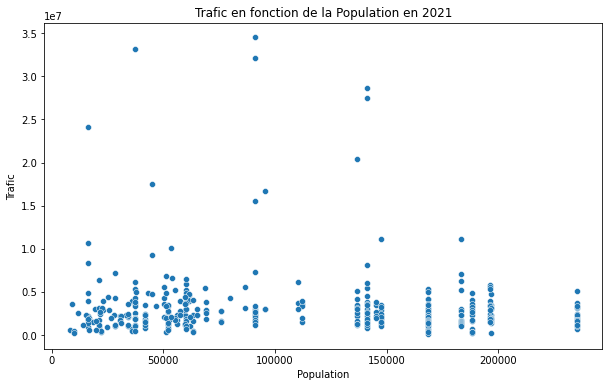

In [ ]:
df_plot = data_set_par_annee[2021][['Population', 'Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Population', y='Trafic', data=df_plot)
plt.title("Trafic en fonction de la Population en 2021")
plt.show()

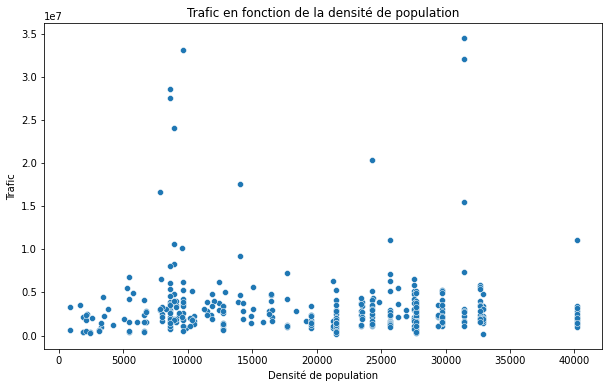

In [ ]:
df_plot = data_set_par_annee[2021][['Population', 'Superficie', 'Trafic']]
df_plot = df_plot.dropna()
df_plot.at[:, 'Densité de population'] = df_plot['Population'] / df_plot['Superficie']
plt.figure(figsize=(10,6))
sns.scatterplot(x='Densité de population', y='Trafic', data=df_plot)
plt.xlabel('Densité de population')
plt.ylabel('Trafic')
plt.title('Trafic en fonction de la densité de population')
plt.show()

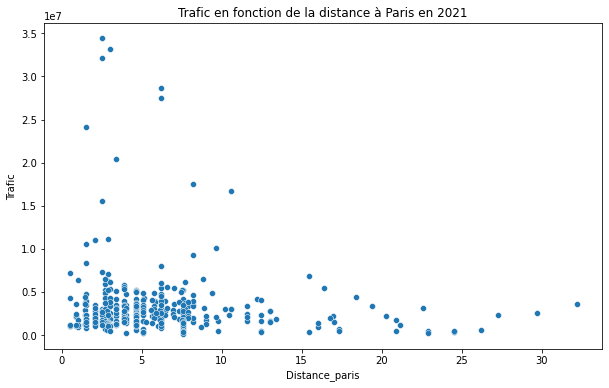

In [ ]:
df_plot = data_set_par_annee[2021][['Distance_paris','Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Distance_paris', y='Trafic', data=df_plot)
plt.title("Trafic en fonction de la distance à Paris en 2021")
plt.show()

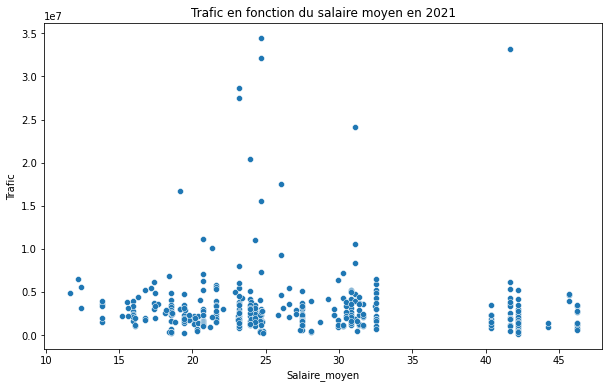

In [ ]:
df_plot = data_set_par_annee[2021][['Salaire_moyen','Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Salaire_moyen', y='Trafic', data=df_plot)
plt.title("Trafic en fonction du salaire moyen en 2021")
plt.show()

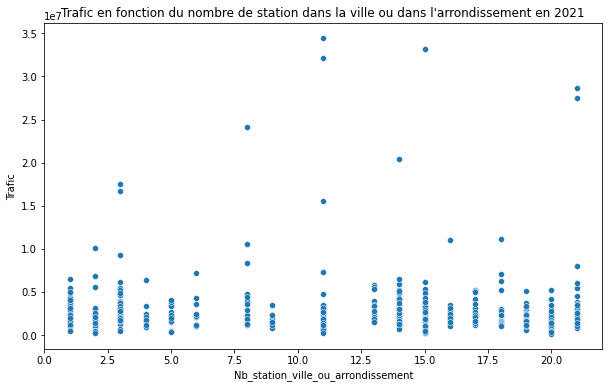

In [ ]:
df_plot = data_set_par_annee[2021][['Nb_station_ville_ou_arrondissement','Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Nb_station_ville_ou_arrondissement', y='Trafic', data=df_plot)
plt.title("Trafic en fonction du nombre de station dans la ville ou dans l'arrondissement en 2021")
plt.show()

In [ ]:
data_set_par_annee[2021].dtypes

Rang                                    int64
Réseau                                 object
Station                                object
Trafic                                  int64
Ville                                  object
Arrondissement pour Paris             float64
A                                        bool
B                                        bool
1                                        bool
2                                        bool
3                                        bool
3bis                                     bool
4                                        bool
5                                        bool
6                                        bool
7                                        bool
7bis                                     bool
8                                        bool
9                                        bool
10                                       bool
11                                       bool
12                                

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Sélectionnez des colonnes à utiliser comme features
features = data_set_par_annee[2021].drop(columns=['Ville','Trafic','Arrondissement pour Paris','Rang','Station','Réseau'])

# Sélection la colonne cible ('Trafic')
target = data_set_par_annee[2021]['Trafic']

# Séparation de mes données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


Régression linéaire :

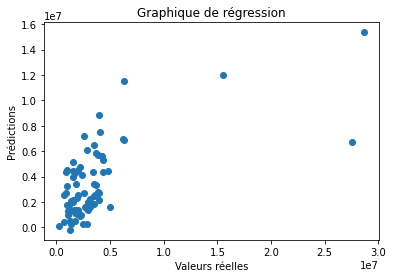

MSE =11810732221995.96
R2 =0.4305563218987395
MAE =1932223.6787914212


In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Graphique de régression')
plt.show()

print ("MSE ="+ str(mse))
print ("R2 ="+ str(r2))
print ("MAE ="+ str(mae))

Le modèle linéaire n'est pas bon du tout (sans trop de surprise). Je vais tester d'autres modèles.

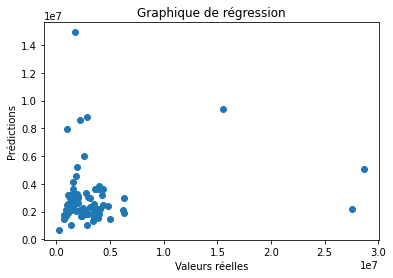

MSE =23071482206615.523
R2 =-0.11237046442516663
MAE =2414038.3200000003


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

# Entraîner le modèle sur le jeu de données d'entraînement
knn.fit(X_train, y_train)

# Prédire sur l'échantillon de test
y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Graphique de régression')
plt.show()

print ("MSE ="+ str(mse))
print ("R2 ="+ str(r2))
print ("MAE ="+ str(mae))

In [ ]:
import tensorflow as tf

# Sélectionnez des colonnes à utiliser comme features
features = data_set_par_annee[2021].drop(columns=['Ville','Trafic','Arrondissement pour Paris','Rang','Station','Réseau']+liste_ligne)

# Sélection la colonne cible ('Trafic')
target = data_set_par_annee[2021]['Trafic']

# Séparation de mes données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


# Convertissez les données en tenseurs
X_train_tensor = tf.convert_to_tensor(X_train)
y_train_tensor = tf.convert_to_tensor(y_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_test_tensor = tf.convert_to_tensor(y_test)


# Créez un modèle de réseau de neurones
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[X_train_tensor.shape[1]]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compilez le modèle
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss=tf.keras.losses.MeanSquaredError())

# Entraînez le modèle
model.fit(X_train_tensor, y_train_tensor, epochs=10, verbose=2)

# Évaluez le modèle sur le jeu de test
results = model.evaluate(X_test_tensor, y_test_tensor,batch_size=128)
print(results)


Epoch 1/10
10/10 - 1s - loss: 26961569120256.0000 - 943ms/epoch - 94ms/step
Epoch 2/10
10/10 - 0s - loss: 26782401036288.0000 - 19ms/epoch - 2ms/step
Epoch 3/10
10/10 - 0s - loss: 26622895849472.0000 - 21ms/epoch - 2ms/step
Epoch 4/10
10/10 - 0s - loss: 26451795509248.0000 - 23ms/epoch - 2ms/step
Epoch 5/10
10/10 - 0s - loss: 26269875961856.0000 - 21ms/epoch - 2ms/step
Epoch 6/10
10/10 - 0s - loss: 26064178905088.0000 - 29ms/epoch - 3ms/step
Epoch 7/10
10/10 - 0s - loss: 25837793443840.0000 - 33ms/epoch - 3ms/step
Epoch 8/10
10/10 - 0s - loss: 25594555269120.0000 - 26ms/epoch - 3ms/step
Epoch 9/10
10/10 - 0s - loss: 25337131958272.0000 - 21ms/epoch - 2ms/step
Epoch 10/10
10/10 - 0s - loss: 25045806088192.0000 - 22ms/epoch - 2ms/step
1/1 [==============================] - 0s 124ms/step - loss: 29886706089984.0000
29886706089984.0


# Test en excluant les stations à multiple correspondances

In [ ]:
df_sans_multiple_correspondance=data_set_par_annee[2021][(data_set_par_annee[2021]['nb_correspondances'] == 1)]

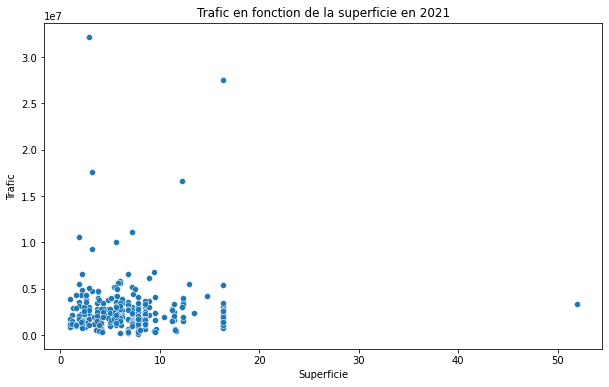

In [ ]:
df_plot = df_sans_multiple_correspondance[['Superficie', 'Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Superficie', y='Trafic', data=df_plot)
plt.title("Trafic en fonction de la superficie en 2021")
plt.show()

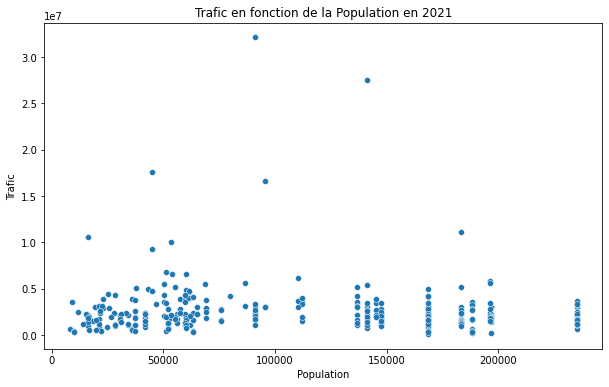

In [ ]:
df_plot = df_sans_multiple_correspondance[['Population', 'Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Population', y='Trafic', data=df_plot)
plt.title("Trafic en fonction de la Population en 2021")
plt.show()

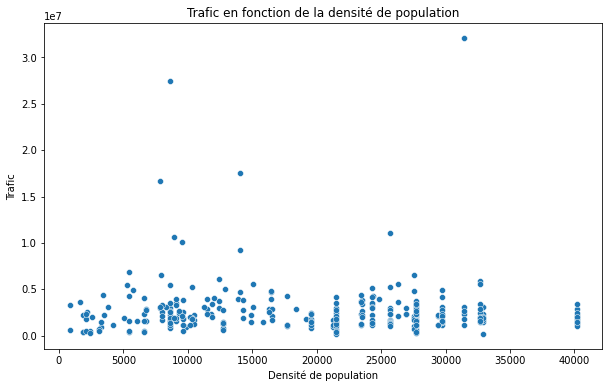

In [ ]:
df_plot = df_sans_multiple_correspondance[['Population', 'Superficie', 'Trafic']]
df_plot = df_plot.dropna()
df_plot.at[:, 'Densité de population'] = df_plot['Population'] / df_plot['Superficie']
plt.figure(figsize=(10,6))
sns.scatterplot(x='Densité de population', y='Trafic', data=df_plot)
plt.xlabel('Densité de population')
plt.ylabel('Trafic')
plt.title('Trafic en fonction de la densité de population')
plt.show()

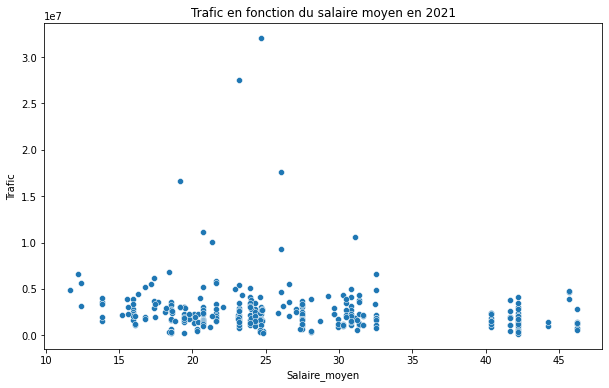

In [ ]:
df_plot = df_sans_multiple_correspondance[['Salaire_moyen','Trafic']]
plt.figure(figsize=(10,6))
sns.scatterplot(x='Salaire_moyen', y='Trafic', data=df_plot)
plt.title("Trafic en fonction du salaire moyen en 2021")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Sélectionnez des colonnes à utiliser comme features
features = df_sans_multiple_correspondance.drop(columns=['Ville','Trafic','Arrondissement pour Paris','Rang','Station','Réseau'])

# Sélection la colonne cible ('Trafic')
target = df_sans_multiple_correspondance['Trafic']

# Séparation de mes données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

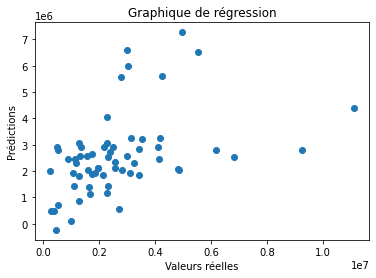

MSE =3614611883754.5244
R2 =0.09948808398869391
MAE =1331807.1041262867


In [ ]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Graphique de régression')
plt.show()

print ("MSE ="+ str(mse))
print ("R2 ="+ str(r2))
print ("MAE ="+ str(mae))

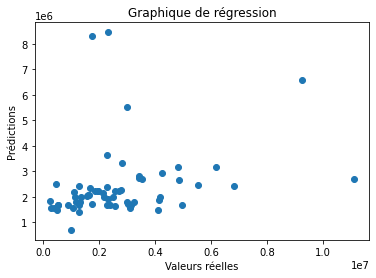

MSE =4437448924486.306
R2 =-0.10550614054884999
MAE =1408222.3322580645


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

# Entraîner le modèle sur le jeu de données d'entraînement
knn.fit(X_train, y_train)

# Prédire sur l'échantillon de test
y_pred = knn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

plt.scatter(y_test, y_pred)
plt.xlabel('Valeurs réelles')
plt.ylabel('Prédictions')
plt.title('Graphique de régression')
plt.show()

print ("MSE ="+ str(mse))
print ("R2 ="+ str(r2))
print ("MAE ="+ str(mae))

In [ ]:
import tensorflow as tf

# Sélectionnez des colonnes à utiliser comme features
features = df_sans_multiple_correspondance.drop(columns=['Ville','Trafic','Arrondissement pour Paris','Rang','Station','Réseau']+liste_ligne)

# Sélection la colonne cible ('Trafic')
target = df_sans_multiple_correspondance['Trafic']

# Séparation de mes données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


# Convertissez les données en tenseurs
X_train_tensor = tf.convert_to_tensor(X_train)
y_train_tensor = tf.convert_to_tensor(y_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_test_tensor = tf.convert_to_tensor(y_test)


# Créez un modèle de réseau de neurones
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[X_train_tensor.shape[1]]),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compilez le modèle
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001),
              loss=tf.keras.losses.MeanSquaredError())

# Entraînez le modèle
model.fit(X_train_tensor, y_train_tensor, epochs=10, verbose=2)

# Évaluez le modèle sur le jeu de test
results = model.evaluate(X_test_tensor, y_test_tensor,batch_size=128)
print(results)

Epoch 1/10
8/8 - 1s - loss: 16633864126464.0000 - 936ms/epoch - 117ms/step
Epoch 2/10
8/8 - 0s - loss: 16463114010624.0000 - 17ms/epoch - 2ms/step
Epoch 3/10
8/8 - 0s - loss: 16319891111936.0000 - 20ms/epoch - 3ms/step
Epoch 4/10
8/8 - 0s - loss: 16182933454848.0000 - 20ms/epoch - 3ms/step
Epoch 5/10
8/8 - 0s - loss: 16046783201280.0000 - 20ms/epoch - 3ms/step
Epoch 6/10
8/8 - 0s - loss: 15901379264512.0000 - 24ms/epoch - 3ms/step
Epoch 7/10
8/8 - 0s - loss: 15748087939072.0000 - 17ms/epoch - 2ms/step
Epoch 8/10
8/8 - 0s - loss: 15581420978176.0000 - 20ms/epoch - 3ms/step
Epoch 9/10
8/8 - 0s - loss: 15409559371776.0000 - 21ms/epoch - 3ms/step
Epoch 10/10
8/8 - 0s - loss: 15232871170048.0000 - 19ms/epoch - 2ms/step
1/1 [==============================] - 0s 151ms/step - loss: 9226232528896.0000
9226232528896.0


Pour l'instant, je n'obtiens pas de modèlation adéquate mais je continue mes expérimentations.